In [1]:
import pandas as pd
import datarobot as dr
import os
import matplotlib.pyplot as plt
%matplotlib inline

# 
# Connect to DataRobot
# 
dr.Client(token=os.environ['DATAROBOT_API_TOKEN'], endpoint='https://app.datarobot.com/api/v2')

# Get an existing project and model 
# This is a lending club project and an elastic net classifier with a
# beta coefficient badge and known to have the matrix n-gram coefficients
project_id = '5bcf5d3cb64ee905a66dbe83'
model_id = '5bcf64139775b62e7e84bade'

project = dr.Project.get(project_id=project_id)
model = dr.Model.get(project=project_id, model_id=model_id)

# Get text coefficients from the model parameters 
mp = model.get_parameters()
# mp.derived_features[:3] . # See what the data sctructur looks like:  nested dicts

# Read derived features into a dataframe
derived_feats = pd.DataFrame(mp.derived_features)
print(derived_feats.shape)
derived_feats.head()

(15029, 6)


,coefficient,derived_feature,original_feature,stage_coefficients,transformations,type
0,0.019611,addr_state-AL,addr_state,[],"[{'name': 'One-hot', 'value': ''AL''}]",CAT
1,0.005755,addr_state-AR,addr_state,[],"[{'name': 'One-hot', 'value': ''AR''}]",CAT
2,0.036465,addr_state-AZ,addr_state,[],"[{'name': 'One-hot', 'value': ''AZ''}]",CAT
3,0.039670,addr_state-CA,addr_state,[],"[{'name': 'One-hot', 'value': ''CA''}]",CAT
4,-0.011949,addr_state-CO,addr_state,[],"[{'name': 'One-hot', 'value': ''CO''}]",CAT


In [2]:
#
# Flatten derived features (nested name, value transformations pairs) via apply 
#
df = derived_feats.copy()
df['transform1'] = None
df['value1'] = None
df['transform2'] = None
df['value2'] = None

def func(row):
    for i, pair in enumerate(row['transformations']):
        name = pair.get('name')
        val = pair.get('value')
        col_name_n = 'transform' + str(i+1)
        col_val_n = 'value' + str(i+1)
        row[col_name_n] = name
        row[col_val_n] = val
    return row
df = df.apply(lambda row: func(row), axis=1)
del df['transformations']
print(df.shape)
df.head()

(15029, 9)


,coefficient,derived_feature,original_feature,stage_coefficients,type,transform1,value1,transform2,value2
0,0.019611,addr_state-AL,addr_state,[],CAT,One-hot,'AL',None,None
1,0.005755,addr_state-AR,addr_state,[],CAT,One-hot,'AR',None,None
2,0.036465,addr_state-AZ,addr_state,[],CAT,One-hot,'AZ',None,None
3,0.039670,addr_state-CA,addr_state,[],CAT,One-hot,'CA',None,None
4,-0.011949,addr_state-CO,addr_state,[],CAT,One-hot,'CO',None,None


count    14803.000000
mean         0.000116
std          0.002442
min         -0.077703
25%         -0.000397
50%         -0.000196
75%          0.000528
max          0.081955
Name: coefficient, dtype: float64

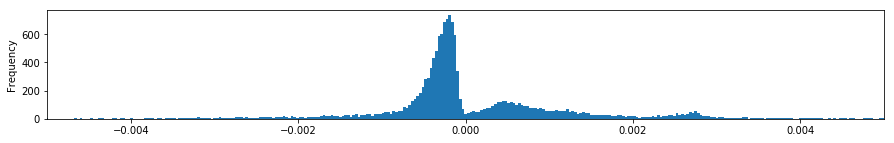

In [3]:
#
# Plot a distributuon of the coefficients
#
fig, ax = plt.subplots(1,1,figsize=[15,2])
plt.xlim([-.005,.005])
df[df.type=='TXT']['coefficient'].plot(kind='hist', bins=5000, ax=ax)
df[df.type=='TXT']['coefficient'].describe()